# Lecture 15 Ensemble Methods <a id="section0"/>

- [15.1 Ensemble Methods](#section1)
- [15.2 Loading the Dataset](#section2)
- [15.3 Voting Ensemble](#section3)
- [15.4 Bagging Ensemble](#section4)
- [15.5 Boosting Ensemble](#section5)
    - [15.5.1 Gradient Boosting Ensemble](#section6)
    - [15.5.2 AdaBoost Ensemble](#section7)
- [15.6 Stacking Ensemble](#section8)
- [15.7 Extreme Gradient Boosting Ensemble](#section9)
- [References](#section10)

# 15.1 Ensemble Methods <a id="section1"/>

***Ensemble methods*** combine the predictions of several other machine learning models, where by averaging the results of all models trained on the same dataset, ensembles can typically achieve better performance than any individual model. Ensemble models can be used for different tasks, including classification and regression. In this lecture, we will focus on ensemble classifiers.

When we introduced scikit-learn we mentioned that Random Forest is an example of ensemble model, since it combined a multitude of Decision Tree models to make predictions. 

Ensembles are one of the most powerful machine learning methods, and they are often employed in the winning solutions in many Machine Learning competitions. 

Ensemble models are classified into four general groups:

* Voting Methods: make predictions based on majority voting of the individual models.
* Bagging Methods: train individual models on random subsets of the training data. Examples are Random Forests, Extra Trees.
* Boosting Methods: train individual models sequentialy by learning from the mistakes. Examples are Gradient Boosting, AdaBoost, XGBoost. 
* Stacking Methods: train individual models, and use another model to aggregate their predictions. 

Most of the above ensemble methods are implemented in scikit-learn, except for XGBoost.

# 15.2 Loading the Dataset <a id="section2"/>

To demonstrate the working principles of ensemble methods, we will use a dataset of electricity usage in New South Wales, Australia. In that market, electricity prices are not fixed and they are set every five minutes based on demand and supply of the market. 

We will train a classifier to predict whether the electricity price will go UP or DOWN the next time the price is set. 

The dataset contains 45,312 rows of data from 7 May 1996 to 5 December 1998. Each row of the dataset refers to a period of 30 minutes, it has information about the date and day of the week, and has other features related to electricity demand, schedule transfer, etc. 

Let's load the dataset `electricity_data` using pandas. 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt

# Let's hide warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
elec_df = pd.read_csv('data/electricity_data.csv')

Let's inspect it. The `date` column does not show the actual date correctly, but we will use it as is, because the date has already been encoded into an adequate numerical format.

The `class` column contains the target labels for the classification task, where we would like to predict whether the electricity price will go UP or DOWN.

In [3]:
elec_df.head(10)

,date,day,period,nswprice,nswdemand,vicprice,vicdemand,transfer,class
0,0.0,2,0.000000,0.056443,0.439155,0.003467,0.422915,0.414912,UP
1,0.0,2,0.021277,0.051699,0.415055,0.003467,0.422915,0.414912,UP
2,0.0,2,0.042553,0.051489,0.385004,0.003467,0.422915,0.414912,UP
3,0.0,2,0.063830,0.045485,0.314639,0.003467,0.422915,0.414912,UP
4,0.0,2,0.085106,0.042482,0.251116,0.003467,0.422915,0.414912,DOWN
5,0.0,2,0.106383,0.041161,0.207528,0.003467,0.422915,0.414912,DOWN
6,0.0,2,0.127660,0.041161,0.171824,0.003467,0.422915,0.414912,DOWN
7,0.0,2,0.148936,0.041161,0.152782,0.003467,0.422915,0.414912,DOWN
8,0.0,2,0.170213,0.041161,0.134930,0.003467,0.422915,0.414912,DOWN
9,0.0,2,0.191489,0.041161,0.140583,0.003467,0.422915,0.414912,DOWN


### Exploratory Data Analysis

In [4]:
elec_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45312 entries, 0 to 45311
Data columns (total 9 columns):
date         45312 non-null float64
day          45312 non-null int64
period       45312 non-null float64
nswprice     45312 non-null float64
nswdemand    45312 non-null float64
vicprice     45312 non-null float64
vicdemand    45312 non-null float64
transfer     45312 non-null float64
class        45312 non-null object
dtypes: float64(7), int64(1), object(1)
memory usage: 3.1+ MB


From the summary statistics below, we can tell that the maximum value in each column is 1 and the minimum is 0, meaning that the features are already normalized, so we don't need to apply data scaling. This does not apply to the `day` column that has values between 1 and 7 (i.e., Monday to Sunday), but we can leave that column as is. 

In [5]:
# summary statistics
elec_df.describe()

,date,day,period,nswprice,nswdemand,vicprice,vicdemand,transfer
count,45312.000000,45312.000000,45312.000000,45312.000000,45312.000000,45312.000000,45312.000000,45312.000000
mean,0.499080,4.003178,0.500000,0.057868,0.425418,0.003467,0.422915,0.500526
std,0.340308,1.998695,0.294756,0.039991,0.163323,0.010213,0.120965,0.153373
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.031934,2.000000,0.250000,0.035127,0.309134,0.002277,0.372346,0.414912
50%,0.456329,4.000000,0.500000,0.048652,0.443693,0.003467,0.422915,0.414912
75%,0.880547,6.000000,0.750000,0.074336,0.536001,0.003467,0.469252,0.605702
max,1.000000,7.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
# Checking missing values
elec_df.isnull().sum()

date         0
day          0
period       0
nswprice     0
nswdemand    0
vicprice     0
vicdemand    0
transfer     0
class        0
dtype: int64

Let's see how many UPs and DOWNs are in the `class` column.

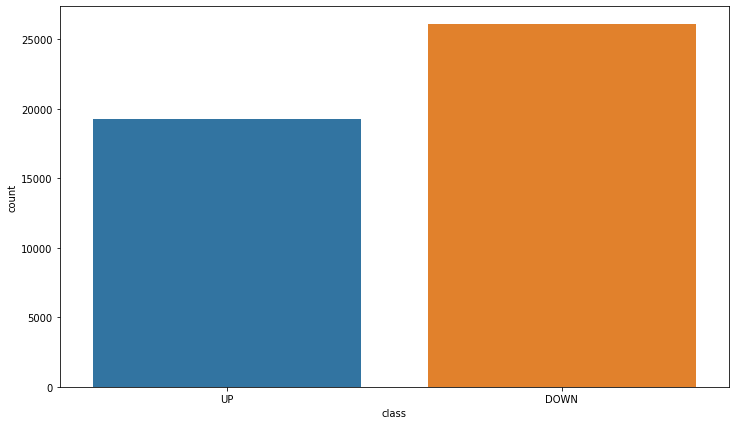

In [7]:
plt.figure(figsize=(12,7))
sns.countplot(data=elec_df, x='class')

Let's also inspect the UPs and DOWNs of the electricity price for each day of the week. 

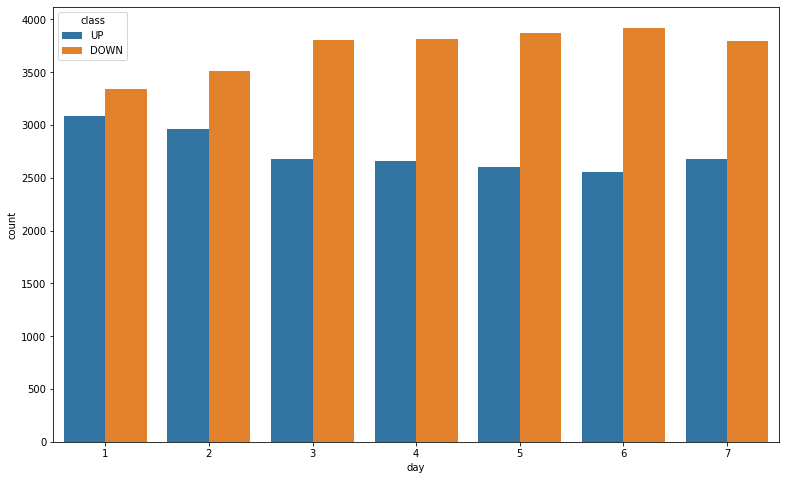

In [8]:
plt.figure(figsize=(13,8))
sns.countplot(data=elec_df, x='day', hue='class')
plt.show()

We can also plot all histograms of the numerical features, and quickly check the plots.

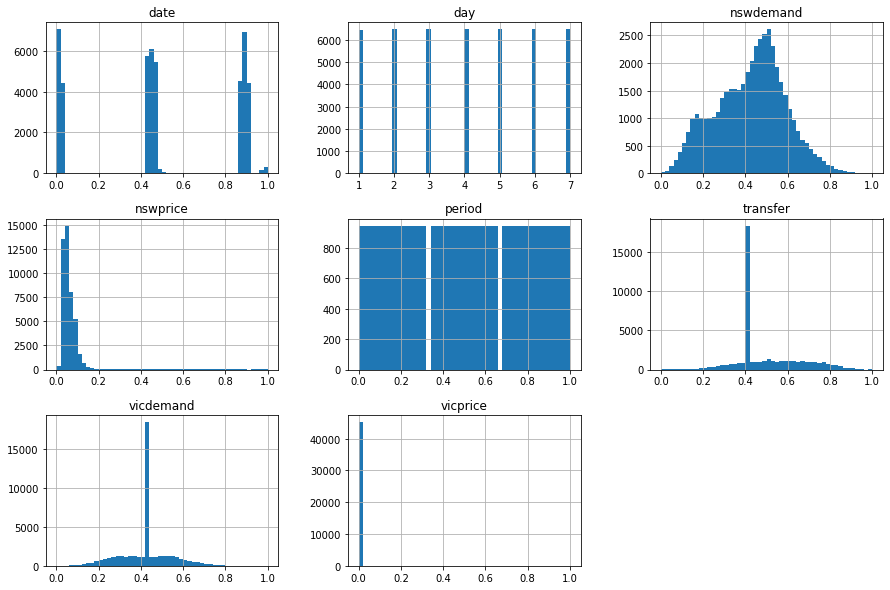

In [9]:
elec_df.hist(bins=50, figsize=(15,10))
plt.show()

### Data Preprocessing 

We will assign the data to the name `X` and targets (the column `class`) to `y`.

In [10]:
X = elec_df.drop('class', axis=1)
y = elec_df['class']

Since the target feature `class` is categorical, let's encode it to ordinal features using Label Encoder. 

In [11]:
from sklearn.preprocessing import LabelEncoder

label_enc = LabelEncoder()
y = label_enc.fit_transform(y)

In [12]:
y

array([1, 1, 1, ..., 0, 1, 0])

Let's split the data into training and test sets. 

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=20)

In [14]:
print('Training data inputs', X_train.shape)
print('Training labels', y_train.shape)
print('Testing data inputs', X_test.shape)
print('Testing labels', y_test.shape)

Training data inputs (33984, 8)
Training labels (33984,)
Testing data inputs (11328, 8)
Testing labels (11328,)


# 15.3 Voting Ensemble <a id="section3"/>

Let's assume that we have trained several different classifiers on the training data, but none of these classifiers had an outstanding result. 

***Voting ensemble*** is the simplest ensemble technique, which aggregates the predictions of the individual classifiers and assigns the predicted class labels based on the majority votes of the single classifiers. 

For example:
- Classifier 1 predicts class A
- Classifier 2 predicts class B
- Classifier 3 predicts class B
- Ensemble majority voting: class B (2 votes), class A (1 vote). Prediction: class B.

Let's first train 3 classifiers on the training data: Logistic Regression, Support Vector Machines, and SGD. Afterward, we will use a voting ensemble that uses their results to make a prediction. 

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

lr_model = LogisticRegression()

# train
lr_model.fit(X_train, y_train)

# evaluate
lr_preds = lr_model.predict(X_test)
lr_acc = accuracy_score(y_test, lr_preds)
print('Logistic Regression accuracy is {0:7.4f} %'.format(lr_acc*100))

Logistic Regression accuracy is 75.5120 %


In [16]:
from sklearn.svm import SVC

svm_model = SVC(random_state=1)

# train
svm_model.fit(X_train, y_train)

# evaluate
svm_preds = svm_model.predict(X_test)
svm_acc = accuracy_score(y_test, svm_preds)
print('SVM accuracy is {0:7.4f} %'.format(svm_acc*100))

SVM accuracy is 75.5120 %


In [17]:
from sklearn.linear_model import SGDClassifier

sgd_model = SGDClassifier(random_state=1)

# train
sgd_model.fit(X_train, y_train)

# evaluate
sgd_preds = sgd_model.predict(X_test)
sgd_acc = accuracy_score(y_test, sgd_preds)
print('SGD accuracy is {0:7.4f} %'.format(sgd_acc*100))

SGD accuracy is 75.3708 %


In [18]:
print('Accuracy: Logistic Regression {0:7.4f}; SVM {1:7.4f}; SGD {2:7.4f}'.format(lr_acc*100, svm_acc*100, sgd_acc*100))

Accuracy: Logistic Regression 75.5120; SVM 75.5120; SGD 75.3708


In scikit-learn we will import `Voting Classifier` to aggregate the results of those 3 classifiers. In the cell below, the models are listed in the `estimators` argument, and afterward the `Voting Classifier` is fit on the training data. The voting argument `hard`  means that the algorithm uses the predicted class labels for majority voting.

In [19]:
from sklearn.ensemble import VotingClassifier

voting_classifier = VotingClassifier(
    
    estimators=[('log_reg', lr_model),
                ('svc', svm_model),
                ('sgd', sgd_model)], 
    voting='hard')

voting_classifier.fit(X_train, y_train)

VotingClassifier(estimators=[('log_reg',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='warn',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='warn', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('svc',
                              SVC(C=1.0, cache_size=200, class_weight=None,
                                  coef0=0.0, decision_funct...
                                            class_weight=None,
                                            ear

In [20]:
# evaluate
voting_preds = voting_classifier.predict(X_test)
voting_acc = accuracy_score(y_test, voting_preds)
print('Voting Ensemble accuracy is {0:7.4f} %'.format(voting_acc*100))

Voting Ensemble accuracy is 75.7415 %


The Voting Ensemble achieved slightly higher accuracy than the three models. 

Beside `hard` voting, another alternative for the voting ensemble classifier is to change the argument to `voting='soft'`. In this case, the decision by the ensemble is made based on the average of the class with the highest probabilities of all individual classifiers. 

Example of soft voting:
- Classifier 1 predicts class A with probability 90%
- Classifier 2 predicts class A with probability 45%
- Classifier 3 predicts class A with probability 45%
- Ensemble probabilities: class A ((90 + 45 + 45) / 3 = 60%), class B ((10 + 55 + 55) / 3 = 40%). Prediction: class A.

Soft voting generally achieves better performance than hard voting, because it assigns higher weight to the predictions by the individual models with high confidence.

In the cell below, to apply soft voting with SVC we need to change the argument `probability=True`, as well as this approach requires to modify the outputs of the SGD model, and instead of SGD we will use a k-Nearest Neighbors model.

In [21]:
from sklearn import neighbors

knn_model = neighbors.KNeighborsClassifier()
svm_classifier = SVC(gamma="auto", probability=True)

voting_classifier_soft = VotingClassifier(
    
    estimators=[('log_reg', lr_model),
                ('svc', svm_classifier),
                 ('knn', knn_model)], 
     voting='soft')

voting_classifier_soft.fit(X_train, y_train)

VotingClassifier(estimators=[('log_reg',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='warn',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='warn', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('svc',
                              SVC(C=1.0, cache_size=200, class_weight=None,
                                  coef0=0.0, decision_function_shape='ovr',
                                  degree=3, gamma='auto', kernel='rbf',
                         

In [22]:
# evaluate
voting_preds = voting_classifier_soft.predict(X_test)
voting_acc = accuracy_score(y_test, voting_preds)
print('Voting Ensemble accuracy is {0:7.4f} %'.format(voting_acc*100))

Voting Ensemble accuracy is 80.7821 %


Even in the cases when the individual models are *weak learners,* which means that they predict slightly better than random guessing, ensemble learning can result in a *strong learner*, which means that it has high prediction accuracy, as long as a large number of diverse individual models are used. 

In general, ensemble methods produce the best results when the individual models are independent of each other, e.g., they use different type of learning algorithms. This way, the individual models can produce diverse results, which can increase the chance that the ensembling will be more successful. Conversely, if the individual models use the same learning algorithm, they will probably make the same type of errors, which will reduce the accuracy when an ensemble method is used. 

# 15.4 Bagging Ensemble <a id="section4"/>

One way to create diverse individual models is to train them on different portions of the training data. Hence, instead of training different models on the same data and averaging their results with a Voting Ensemble, ***Bagging Ensemble*** method trains a single or multiple models on different subsets of the training data and aggregates the results. 

The term **bagging** is short for *bootstrap aggregating*, where bootstrapping refers to sampling subsets from the training data with replacement. In other words, the subsets of the training data used by different models can contain the same data points. When the subsets are sampled without replacement, it is called *pasting*.

The aggregation of the predictions by the individual models is typically based on the most frequent prediction, similar to hard voting. The individual models used with bagging are typically Decision Trees.

In scikit-learn we can import a Bagging Classifier, and fit it to the training data. Let's use bagging to train  decision trees on different subsets of the data and then average the predictions on those subsets. In the cell below, `max_samples=0.5` means that each model will use a random subset containing 50% of training data, and `max_features=0.5` means that each model will use a random subsets of 50% of the input features. If bootstrap is `True` the training samples will be sampled with replacement, and if it is `False` there is no replacement (i.e., pasting). 

In [23]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bagging_classifier = BaggingClassifier(
      DecisionTreeClassifier(class_weight='balanced'),
    max_samples=0.5, max_features=0.5, bootstrap=True
)

bagging_classifier.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight='balanced',
                                                        criterion='gini',
                                                        max_depth=None,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort=False,
                                                        random_state=None,
                                                        splitter='best')

In [24]:
# evaluate
bagging_preds = bagging_classifier.predict(X_test)
bagging_acc = accuracy_score(y_test, bagging_preds)
print('Bagging Ensemble accuracy is {0:7.4f} %'.format(bagging_acc*100))

Bagging Ensemble accuracy is 83.9954 %


Bagging Ensembles often outperform Voting Ensembles, and they can decrease the overfitting of decision trees (which tend to overfit easily). As well as, bagging ensembles can be trained in parallel using different CPU cores, which can reduce the processing time.  

Random Forest is a bagging ensemble with the `max_samples` set to 1, that is, it samples from the entire training set. It is optimized for Decision Trees, and it can be used instead of the bagging classifier above, when the individual models are Decision Trees. 

# 15.5 Boosting Ensemble <a id="section5"/>

***Boosting Ensemble*** trains the individual models sequentially, where each single next model has access to the predictions of the previous models and attempts to improve the performance. The term *boosting* refers to incremental improvement by reducing the errors of the predecessors, in order to convert weak learners into a strong learner.

The most popular boosting ensembles are Gradient Boosting, AdaBoost, and XGBoost. 

## 15.5.1 Gradient Boosting Ensemble <a id="section6"/>

***Gradient Boosting Ensemble*** fits the individual models sequentially, where each new model is fit to reduce the errors made by the previous model. The individual models in gradient boosting are Decision Trees. 

In this method, the initial model is trained on the full data, and residual errors are obtained based on the difference between the predicted class of the model and the target label. The next model is trained by using the residual errors of the previous model as a target variable. These steps are repeated for each single model. Ideally, the residuals should become smaller as more individual models are trained, that is, the predictions by the models better match the target labels. 

The residual errors represent the gradient of the loss function with respect to the predicted value. This is the reason why the method is called gradient boosting.

In scikit-learn, gradient boosting classifier has hyperparameters related to the number of estimators or trees (`n_estimators`), learning rate (`learning_rate`), maximum depth of the trees (`max_depth`), and others.  The learning rate is typically set to values between 0.01 and 1, and it defines how quickly the models are updated. If the learning rate is too high, the models will be updated more quickly, which can cause overfitting.

In [25]:
from sklearn.ensemble import GradientBoostingClassifier

grad_boost_classifier = GradientBoostingClassifier(
                        n_estimators=500, 
                        learning_rate=0.8, 
                        random_state=42,
                        max_depth=2)

grad_boost_classifier.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.8, loss='deviance', max_depth=2,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=500,
                           n_iter_no_change=None, presort='auto',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [26]:
# evaluate
gboost_preds = grad_boost_classifier.predict(X_test)
gboost_acc = accuracy_score(y_test, gboost_preds)
print('Gradient Boosting Ensemble accuracy is {0:7.4f} %'.format(gboost_acc*100))

Gradient Boosting Ensemble accuracy is 89.6893 %


There are several variants of Gradient Boosting, and one such variant is Histogram Gradient Boosting Classifier in scikit-learn, which was inspired by [Microsoft's Light Gradient Boosting Machine (LightGBM)](https://github.com/Microsoft/LightGBM). Another variant is Extreme Gradient Boosting explained below.   

## 15.5.2 AdaBoost Ensemble <a id="section7"/>

***AdaBoost Ensemble*** is short of *adaptive boosting*. AdaBoost has similarities to Gradient Boosting, however, instead of minimizing the residual error of the sequential models, it assigns weights to the training data instances based on the difficulty to be classified. The main idea of AdaBoost is to focus the individual models on the training instances that are difficult to classify. 

AdaBoost begins by training a base estimator (which by default is a Decision Tree model) on the full training dataset. After that, higher weights are assigned to the data instances that were misclassified by the previous model. Therefore, the second model will put more attention on correctly predicting the class of the misclassified data instances. By training many models sequentially, the algorithm will try harder to predict the difficult data instances. 

The aggregated prediction by all single models is done by averaging the predictions and using weights for each model based on their accuracy on the training set. 

The main parameters in the AdaBoost Classifier are the type of base estimators and the number of estimators. 

In [27]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

adaboost_classifier = AdaBoostClassifier(
    base_estimator=DecisionTreeClassifier(max_depth=3, class_weight='balanced'), 
    n_estimators=300,
    learning_rate=0.5
)

adaboost_classifier.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(class_weight='balanced',
                                                         criterion='gini',
                                                         max_depth=3,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort=False,
                                                         random_state=None,
                       

In [28]:
# evaluate
adaboost_preds = adaboost_classifier.predict(X_test)
adaboost_acc = accuracy_score(y_test, adaboost_preds)
print('AdaBoost Ensemble accuracy is {0:7.4f} %'.format(adaboost_acc*100))

AdaBoost Ensemble accuracy is 89.8923 %


# 15.6 Stacking Ensemble <a id="section8"/>

***Stacking Ensemble*** is short for *stacked generalization*, where instead of using hard or soft voting for aggregating the results from multiple models, another model is trained to perform the aggregation. 

In the example below, we train two base estimators, SVM classifier and a Random Forest classifier. Afterward, as a final estimator we use Logistic Regression model, which is trained by using the predictions by the two base estimators as inputs. The final estimator aggregates the predictions of the individual models and outputs the final predictions. 

In [28]:
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier

base_estimators = [
    ('rand', RandomForestClassifier(random_state=42)),
    ('svc', SVC(random_state=42))]

final_estimator = LogisticRegression()

stack_classifier = StackingClassifier(estimators = base_estimators, 
                               final_estimator = final_estimator)

stack_classifier.fit(X_train, y_train)

StackingClassifier(estimators=[('rand',
                                RandomForestClassifier(random_state=42)),
                               ('svc', SVC(random_state=42))],
                   final_estimator=LogisticRegression())

In [29]:
# evaluate
stack_preds = stack_classifier.predict(X_test)
stack_acc = accuracy_score(y_test, stack_preds)
print('Stacking Ensemble accuracy is {0:7.4f} %'.format(stack_acc*100))

Stacking Ensemble accuracy is 90.2189 %


# 15.7 Extreme Gradient Boosting Ensemble (XGBoost) <a id="section9"/>

***eXtreme Gradient Boosting Ensemble***, or XGBoost, is an optimized version of Gradient Boosting. It introduced several modifications and optimizations in the Gradient Boosting algorithm, which sped up the training process and improved the predictive performance. At present, XGBoost is one of the most powerful and robust machine learning methods, and its performance is often superior to other methods. It is very fast and scalable to large datasets. And because of these properties, XGBoost is the winning algorithm used in many Kaggle competitions. 

Note that XGBoost is not implemented in Scikit-Learn, and it needs to be installed (`pip install xgboost`). On the other hand, the API is the same as scikit-learn, and uses `fit` and `predict` methods for training and evaluation. 

In [36]:
# pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [29]:
import xgboost as xgb

xgb_classifier = xgb.XGBClassifier()
xgb_classifier.fit(X_train, y_train)

[14:19:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='binary:logistic',
              predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=True, validate_parameters=1, verbosity=None)

In [30]:
# evaluate
xgboost_preds = xgb_classifier.predict(X_test)
xgboost_acc = accuracy_score(y_test, xgboost_preds)
print('XGBoost Ensemble accuracy is {0:7.4f} %'.format(xgboost_acc*100))

XGBoost Ensemble accuracy is 91.1635 %


# References <a id="section10"/>

1. Complete Machine Learning Package, Jean de Dieu Nyandwi, available at: [https://github.com/Nyandwi/machine_learning_complete](https://github.com/Nyandwi/machine_learning_complete).
2. Hands-on Machine Learning with Scikit-learn, Keras & TensorFlow, Aurelien Geron, available at: [https://github.com/ageron/handson-ml/blob/master/07_ensemble_learning_and_random_forests.ipynb](https://github.com/ageron/handson-ml/blob/master/07_ensemble_learning_and_random_forests.ipynb). 
3. Python Machine Learning (2nd Ed.) Code Repository, Sebastian Raschka, available at: [https://github.com/rasbt/python-machine-learning-book-2nd-edition](https://github.com/rasbt/python-machine-learning-book-2nd-edition). 


[BACK TO TOP](#section0)